In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
import math
import utils
from collections import deque
import random
import seaborn as sns
import utils_adv
from sklearn import preprocessing
from keras.layers import Dense, Dropout, LSTM, GRU, BatchNormalization
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
import time

# plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
sns.set_theme()
sns.set_style("whitegrid", {'grid.linestyle': '--'})
seq_col_brew = sns.color_palette("flag_r", 4)
sns.set_palette(seq_col_brew)
plt.rcParams["figure.figsize"] = (7,5)
plt.rcParams["axes.titlesize"] = 15
plt.rcParams['savefig.dpi'] = 1200

tf.keras.utils.set_random_seed(2) # relu

#settings
%reload_ext autoreload
%autoreload 3
%config InteractiveShell.ast_node_interactivity = 'all'
%config InlineBackend.figure_format = 'retina'

In [59]:
SEQ_LEN = 60  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
ASSET_TO_PREDICT = "BTC-USD"

In [60]:
# Read in and preprocess data
ratios = ["BTC-USD", "LTC-USD", "BCH-USD", "ETH-USD"] 
crypto_df = utils_adv.crypto_data_reader(ratios)


dataset_df = crypto_df

dataset_df[f't+1'] = dataset_df[f'{ASSET_TO_PREDICT}_close'].shift(-FUTURE_PERIOD_PREDICT)
dataset_df['target'] = list(map(utils_adv.classify, dataset_df[f'{ASSET_TO_PREDICT}_close'], dataset_df['t+1']))

train_df, validation_df = utils_adv.split(dataset_df)

train_x, train_y = utils_adv.preprocess_df(train_df, SEQ_LEN)
validation_x, validation_y = utils_adv.preprocess_df(validation_df, SEQ_LEN)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/vn/dlt8xpl50tb76_5r7m5gg4vc0000gn/T/ipykernel_71874/1666289901.py", line 3, in <cell line: 3>
    crypto_data = utils_adv.crypto_data_reader(ratios)
  File "/Users/timmiebengtsson/Local_code/msc_project/utils_adv.py", line 136, in crypto_data_reader
    df = df.join(df)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/frame.py", line 9263, in join
    return self._join_compat(
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/frame.py", line 9294, in _join_compat
    return merge(
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/reshape/merge.py", line 122, in merge
    return op.get_r

In [61]:
my_time = time.strftime('%m.%d.%H%M', time.localtime(int(time.time())))
print(my_time)
EPOCHS = 2
BATCH_SIZE = 16
NAME = f"{ASSET_TO_PREDICT}-seq-{SEQ_LEN}-fwd-{FUTURE_PERIOD_PREDICT}---@{my_time}"  # a name for the model

12.22.1622


In [62]:
model = utils_adv.create_model(train_x)

In [63]:
checkpoint_filepath = "models/rnn-checkpoint-{epoch:02d}-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath, 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    mode='max')

In [64]:
# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    callbacks=[checkpoint],
)


Epoch 1/2
4415/4415 [==============================] - ETA: 0s - loss: 0.7007 - accuracy: 0.5392
Epoch 1: val_accuracy improved from -inf to 0.54675, saving model to models/rnn-checkpoint-01-0.547.model


INFO:tensorflow:Assets written to: models/rnn-checkpoint-01-0.547.model/assets


INFO:tensorflow:Assets written to: models/rnn-checkpoint-01-0.547.model/assets


4415/4415 [==============================] - 441s 99ms/step - loss: 0.7007 - accuracy: 0.5392 - val_loss: 0.6859 - val_accuracy: 0.5468
Epoch 2/2
4415/4415 [==============================] - ETA: 0s - loss: 0.6818 - accuracy: 0.5699
Epoch 2: val_accuracy improved from 0.54675 to 0.56766, saving model to models/rnn-checkpoint-02-0.568.model


INFO:tensorflow:Assets written to: models/rnn-checkpoint-02-0.568.model/assets


INFO:tensorflow:Assets written to: models/rnn-checkpoint-02-0.568.model/assets


4415/4415 [==============================] - 429s 97ms/step - loss: 0.6818 - accuracy: 0.5699 - val_loss: 0.6809 - val_accuracy: 0.5677


In [65]:
loss, acc = model.evaluate(validation_x, validation_y, verbose=0)
print("Model, test loss: {:5.2f}".format(loss))
print("Model, test accuracy: {:5.2f}%".format(100 * acc))

print(format(NAME))
model.save(f"models/{NAME}.hdf5")
if hasattr(history, 'history'):
    np.save(f'history/{NAME}.npy',history.history)
    print("Saved history") #should happen at first run of this block after model.fit ran

Test loss: 0.6808844208717346
Test accuracy: 0.5676567554473877


INFO:tensorflow:Assets written to: models/BTC-USD-seq-60-fwd-1---@12.22.1622/assets


INFO:tensorflow:Assets written to: models/BTC-USD-seq-60-fwd-1---@12.22.1622/assets


BTC-USD-seq-60-fwd-1---@12.22.1622


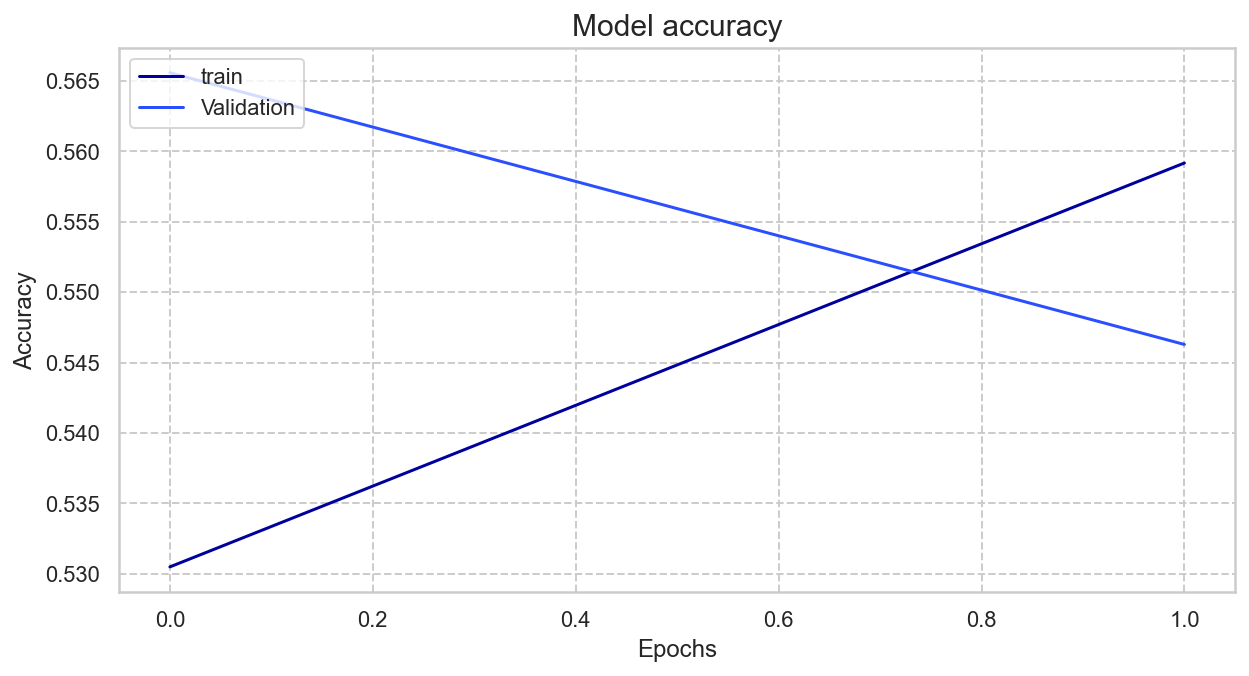

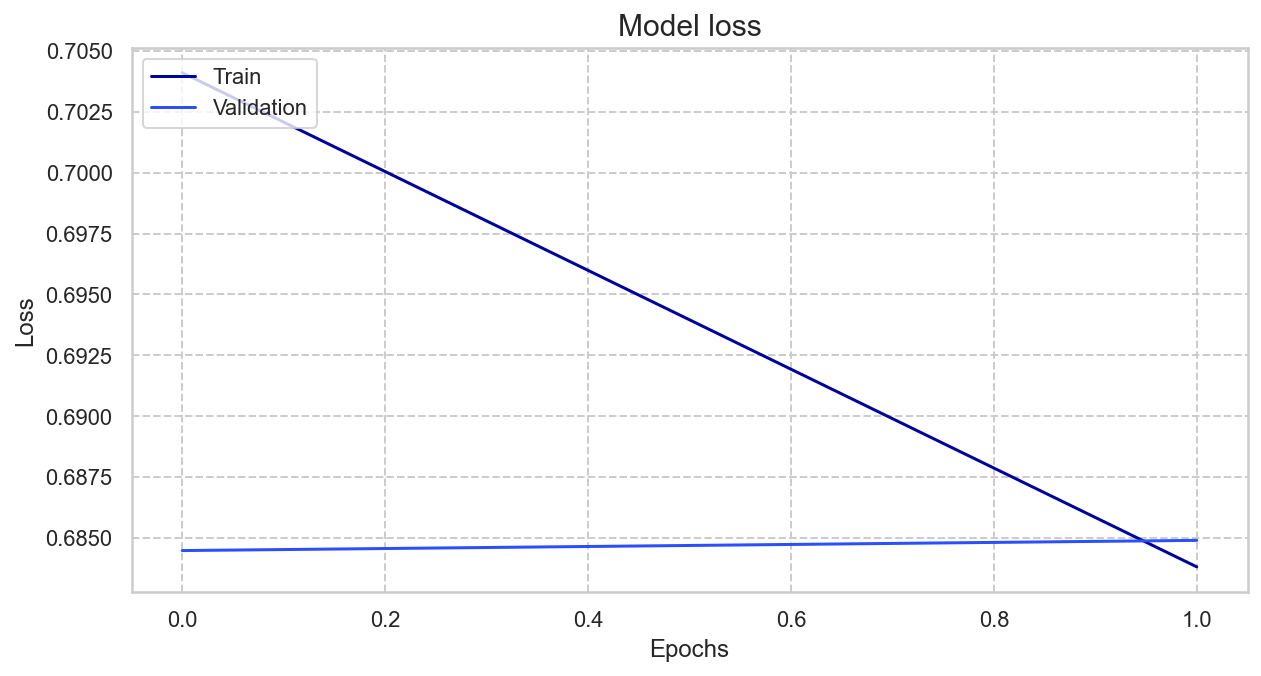

In [72]:
# load back history data
model_name = 'rx1-seq-60-fwd-1---@12.22.2104'
model_load = keras.models.load_model(f'models/{model_name}.hdf5')
history_load = np.load(f'history/{model_name}.npy',allow_pickle='TRUE').item()

loss, acc = model_load.evaluate(validation_x, validation_y, verbose=0)
print("Restored model, test loss: {:5.2f}".format(loss))
print("Restored model, test accuracy: {:5.2f}%".format(100 * acc))

In [ ]:
fig1, axs1, fig2, axs2 = utils_adv.plot_history_data(history_load)

In [67]:
#######################

In [265]:
ratios = ["BTC-USD", "LTC-USD", "BCH-USD", "ETH-USD"]
crypto_df = utils_adv.crypto_data_reader(ratios)

val_df = utils_adv.split(crypto_df)[1]
seq = SEQ_LEN + 1
asset_name = 'BTC-USD_close'

df_rpp = utils_adv.get_rpp(val_df, seq, asset_name, model)

1/1 [==============================] - 0s 31ms/step
61
1/1 [==============================] - 0s 36ms/step
62
1/1 [==============================] - 0s 23ms/step
63
1/1 [==============================] - 0s 23ms/step
64
1/1 [==============================] - 0s 28ms/step
65
1/1 [==============================] - 0s 22ms/step
66
1/1 [==============================] - 0s 23ms/step
67
1/1 [==============================] - 0s 23ms/step
68
1/1 [==============================] - 0s 23ms/step
69
1/1 [==============================] - 0s 23ms/step
70
1/1 [==============================] - 0s 23ms/step
71
1/1 [==============================] - 0s 23ms/step
72
1/1 [==============================] - 0s 22ms/step
73
1/1 [==============================] - 0s 22ms/step
74
1/1 [==============================] - 0s 22ms/step
75
1/1 [==============================] - 0s 23ms/step
76
1/1 [==============================] - 0s 21ms/step
77
1/1 [==============================] - 0s 22ms/step
78
1/1 [=====

In [334]:
first_ten_predictions = df_rpp.loc[0:30, 'pred[0]']
mean = np.mean(first_ten_predictions)
mean

0.49582282

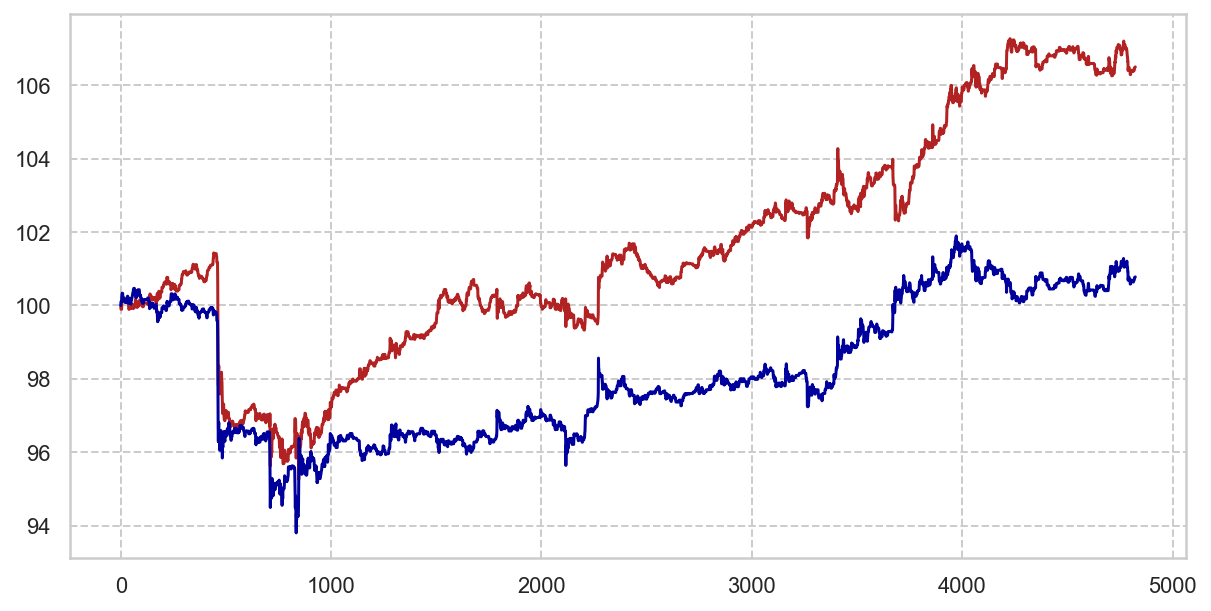

In [335]:
treshhold = mean # 0 = always short, 1 = always long. mean ~ 50/50 short/long
portfolio_value_trading = utils_adv.get_portfolio_value_trading(df_rpp, treshhold)
portfolio_value_hold = utils_adv.get_portfolio_value_hold(df_rpp)

# mean_pred = np.mean(pred_list)
# mean_pred
fig, axs = plt.subplots(1,1, figsize=(10,5))
fig = plt.plot(portfolio_value_trading, color='firebrick', linestyle='-')
fig = plt.plot(portfolio_value_hold)